# Machine Configuration

In [39]:
OMNETPP_PATH = "C:\\omnet\\omnetpp-5.5.1\\"
SDN4CORE_PATH = "/C/Users/Timo/Workspace/omnet/SDN4CoRE/"
# OMNETPP_PATH = "C:\\omnet\\omnetpp-5.5.1\\"
# SDN4CORE_PATH = "/C/Users/micro/workspace/omnet/SDN4CoRE/"
SIMULATION_PATH = SDN4CORE_PATH + "examples/papers/vtc2023spring/scaling/"

In [40]:
import glob
import pandas as pd
import numpy as np
import ntpath
import matplotlib.pyplot as plt
import os
import time
%matplotlib inline

## Helpers:
def parse_if_number(s):
    try: return float(s)
    except: return True if s=="true" else False if s=="false" else s if s else None

def parse_ndarray(s):
    return np.fromstring(s, sep=' ') if s else None

def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail or ntpath.basename(head)

# Scavetool -- parse filtered result files into csv

In [52]:
MODULE_FILTER = "**.publishers**.middleware.**"
RESULTFILES_PATTERNS = {
    # "./results/Switch_Switches_Study*", 
    # "./results/SDN_Switches_Study*",
    "./results/Switch_MultSubPerPub_Study*", 
    "./results/SDN_MultSubPerPub_Study*"
    }

In [53]:
for RESULTFILES_PATTERN in RESULTFILES_PATTERNS:
    resultfiles = glob.glob(RESULTFILES_PATTERN + ".sca")
    for resultfile in resultfiles:
        command = OMNETPP_PATH + "tools\win64\\msys2_shell.cmd -mingw64 -ic \"echo " + resultfile.replace("\\","/").replace(".sca",".*") + "; scavetool x " + SIMULATION_PATH + resultfile.replace("\\","/") + " " + SIMULATION_PATH + resultfile.replace("\\","/").replace(".sca",".vec") + " -T v -f \'module(" + MODULE_FILTER + ")\'" + " -o " + SIMULATION_PATH + resultfile.replace("\\","/").replace(".sca",".csv") + "; sleep 5\""
        os.environ["HOME"] = OMNETPP_PATH
        os.system(command)
        time.sleep(2)


# Parse and Plot

### Switches Study

In [51]:
CSV_FILE_PATTERN = "./results/Switch_Switches_Study*"
# CSV_FILE_PATTERN = "./results/SDN_Switches_Study*"

In [47]:
csv_files = glob.glob(CSV_FILE_PATTERN + ".csv")
lastRemote = dict()
for csv_file in csv_files:
    study = pd.read_csv(csv_file, converters = {
        'attrvalue': parse_if_number,
        'binedges': parse_ndarray,
        'binvalues': parse_ndarray,
        'vectime': parse_ndarray,
        'vecvalue': parse_ndarray})
    filtered = study[(study.type=="vector") & (study.name=="remotes:vector(constant1)")]
    tmp = csv_file.split("-")[1].split(",")
    S = int(tmp[0].split("=")[1])
    N = int(tmp[1].split("=")[1])
    if S not in lastRemote:
        lastRemote[S] = dict()
    lastRemote[S][N] = filtered["vectime"].max()[0]
    # lastRemoteMin[S][N] = filtered["vectime"].min()[0]

In [48]:
df = pd.DataFrame(lastRemote)
df = df.transpose()
df = df.sort_index()
# df.to_csv(CSV_FILE_PATTERN.split('*')[0] + "_switches.csv")


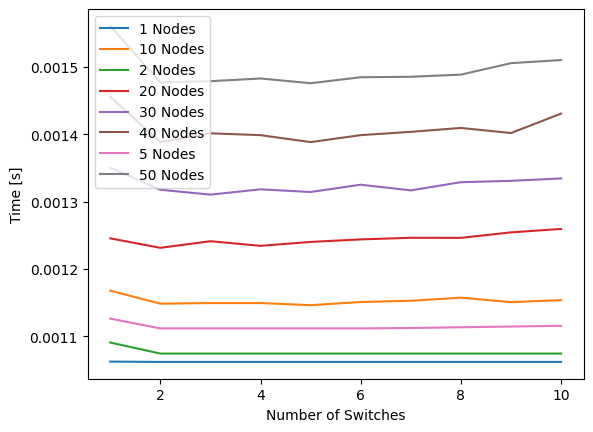

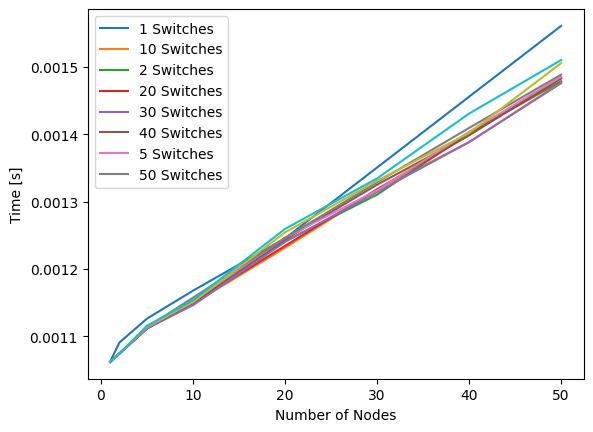

In [49]:
plt11 = df.plot()
plt11.set_xlabel("Number of Switches")
plt11.set_ylabel("Time [s]")
plt11.legend([str(x) + " Nodes" for x in df.columns])
plt11
plt12 = df.transpose().sort_index().plot()
plt12.set_xlabel("Number of Nodes")
plt12.set_ylabel("Time [s]")
plt12.legend([str(x) + " Switches" for x in df.columns])

### Multiple Subscribers per Publisher Study

In [57]:
# CSV_FILE_PATTERN = "./results/Switch_MultSubPerPub_Study*"
CSV_FILE_PATTERN = "./results/SDN_MultSubPerPub_Study*"

In [109]:
csv_files = glob.glob(CSV_FILE_PATTERN + ".csv")
lastRemote = dict()
for csv_file in csv_files:
    study = pd.read_csv(csv_file, converters = {
        'attrvalue': parse_if_number,
        'binedges': parse_ndarray,
        'binvalues': parse_ndarray,
        'vectime': parse_ndarray,
        'vecvalue': parse_ndarray})
    filtered = study[(study.type=="vector") & (study.name=="remotes:vector(constant1)")]
    tmp = csv_file.split("-")[1].split(",")
    P = int(tmp[0].split("=")[1])
    C = int(tmp[1].split("=")[1])
    # print (P, C)
    if P not in lastRemote:
        lastRemote[P] = dict()
    # find the maximum value in the matrix
    # print(type(filtered["vectime"]))
    maximum = 0
    for dim1 in filtered["vectime"]:
        for dim2 in dim1:
            maximum = dim2.max() if dim2.max() > maximum else maximum
    lastRemote[P][C] = maximum
    # lastRemoteMin[P][C] = filtered["vectime"].min()[0]

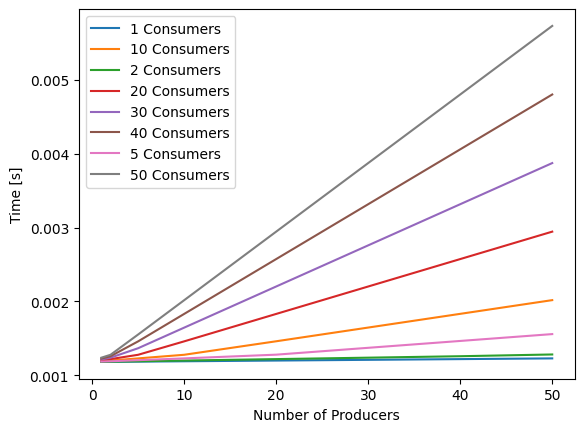

In [110]:
df = pd.DataFrame(lastRemote)
df = df.sort_index()
plt11 = df.plot()
plt11.set_xlabel("Number of Producers")
plt11.set_ylabel("Time [s]")
plt11.legend([str(x) + " Consumers" for x in df.columns])